In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_from_disk

# From Google Drive
dataset_path = "/content/drive/MyDrive/cleaned_balanced_civil_comments"

# load data
dataset = load_from_disk(dataset_path)

dataset

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
    num_rows: 297057
})

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
df = pd.DataFrame(dataset)
df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,haha you guys are a bunch of losers,0.893617,0.021277,0.000000,0.0,0.872340,0.021277,0.000000
1,ur a shtty comment,0.666667,0.047619,0.638095,0.0,0.333333,0.000000,0.009524
2,its ridiculous that these guys are being calle...,0.600000,0.000000,0.100000,0.1,0.600000,0.000000,0.000000
3,this story gets more ridiculous by the hour an...,0.500000,0.000000,0.000000,0.0,0.300000,0.000000,0.000000
4,angry trolls misogynists and racists oh my it ...,0.500000,0.000000,0.000000,0.0,0.500000,0.100000,0.000000


In [ ]:
# Check null or None
print("Null or None values:")
print(df.isnull().sum())

# Check only empty text in the text column
print("\nEmpty string values in 'text':")
print((df["text"] == "").sum())

Null or None values:
text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64

Empty string values in 'text':
0


In [ ]:
# lables
labels = df[df.columns[1:]].values

# texts
texts = df['text'].astype(str).values

In [ ]:
print(type(texts))
print(texts.shape)

<class 'numpy.ndarray'>
(297057,)


In [ ]:
print(type(labels))
print(labels.shape)

<class 'numpy.ndarray'>
(297057, 7)


In [ ]:
filtered_texts = []
filtered_labels = []

for text, label in zip(texts, labels):
    if text.strip():
        filtered_texts.append(text)
        filtered_labels.append(label)

texts = filtered_texts
labels = filtered_labels

In [ ]:
MAX_WORDS=40000

In [ ]:
# Create a vectorizer
vectorizer = TextVectorization(
    max_tokens=MAX_WORDS,
    output_sequence_length=600,
    output_mode='int'
)

# Training the vectorizer on texts
vectorizer.adapt(texts)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# labels is a numpy array
labels = np.array(labels)

# Split train and temp (val + test)
texts_train, texts_temp, labels_train, labels_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels.argmax(axis=1)
)

# Split temp into val and test
texts_val, texts_test, labels_val, labels_test = train_test_split(
    texts_temp, labels_temp, test_size=0.33, random_state=42, stratify=labels_temp.argmax(axis=1)
)


In [ ]:
# Save spilt data
import numpy as np

np.savez_compressed(
    'dataset_splits.npz',
    texts_train=texts_train,
    labels_train=labels_train,
    texts_val=texts_val,
    labels_val=labels_val,
    texts_test=texts_test,
    labels_test=labels_test
)

In [ ]:
# Helper function
def create_dataset(texts, labels):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    ds = ds.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().shuffle(20000).batch(64).prefetch(tf.data.AUTOTUNE)
    return ds

# Apply to the three groups
train = create_dataset(texts_train, labels_train)
val = create_dataset(texts_val, labels_val)
test = create_dataset(texts_test, labels_test)

In [ ]:
import numpy as np

print("Train positive:", np.sum(labels_train.argmax(axis=1) > 0))
print("Val positive:", np.sum(labels_val.argmax(axis=1) > 0))
print("Test positive:", np.sum(labels_test.argmax(axis=1) > 0))

Train positive: 10224
Val positive: 2935
Test positive: 1446


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
model.add(Input(shape=(600,)))
# Create the embedding layer
model.add(Embedding(MAX_WORDS+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
# Final layer
model.add(Dense(7, activation='sigmoid'))

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC
import tensorflow as tf

# Compile with metrics appropriate to the task.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 600, 32)        │     1,280,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,405,735 (5.36 MB)

 Trainable params: 1,405,735 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)


In [ ]:
history = model.fit(train,
                    epochs=13,
                    validation_data=val,
                    batch_size=32,
                    callbacks=[early_stop, checkpoint]
                   )

Epoch 1/13
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 2213s 678ms/step - auc: 0.8177 - loss: 0.2398 - precision: 0.8949 - recall: 0.2337 - val_auc: 0.8909 - val_loss: 0.1939 - val_precision: 0.9751 - val_recall: 0.3406
Epoch 2/13
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 2117s 652ms/step - auc: 0.9118 - loss: 0.1872 - precision: 0.9724 - recall: 0.3498 - val_auc: 0.9211 - val_loss: 0.1832 - val_precision: 0.9598 - val_recall: 0.3943
Epoch 3/13
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 2165s 666ms/step - auc: 0.9285 - loss: 0.1762 - precision: 0.9754 - recall: 0.3759 - val_auc: 0.9254 - val_loss: 0.1830 - val_precision: 0.9757 - val_recall: 0.3550
Epoch 4/13
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 2165s 666ms/step - auc: 0.9369 - loss: 0.1709 - precision: 0.9779 - recall: 0.3857 - val_auc: 0.9271 - val_loss: 0.1858 - val_precision: 0.9696 - val_recall: 0.3739
Epoch 5/13
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 2147s 656ms/step - auc: 0.9442 - loss: 0.1665 - precision: 0.9803 - recall: 0.3976 - val_auc: 0.9203 - val_loss: 0.1940 - val_prec

In [ ]:
model.save('best_modelM40000output_sequence_length600.keras')
print("model saved successfully!")

model saved successfully!


933/933 ━━━━━━━━━━━━━━━━━━━━ 125s 133ms/step

Confusion Matrix for 'toxicity':
[[18492 12104]
 [17611 11500]]


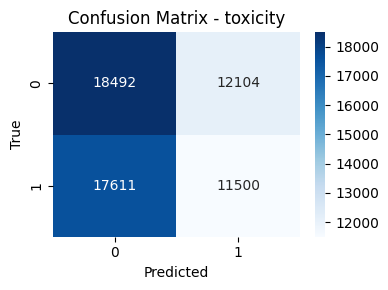


Confusion Matrix for 'severe_toxicity':
[[59705     0]
 [    2     0]]


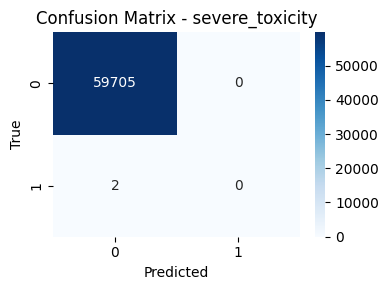


Confusion Matrix for 'obscene':
[[56375  1367]
 [ 1920    45]]


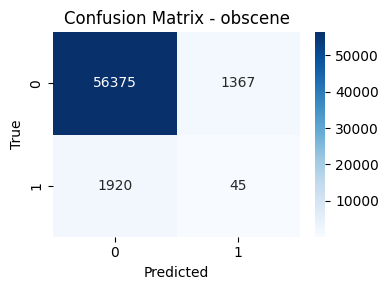


Confusion Matrix for 'threat':
[[58425   389]
 [  889     4]]


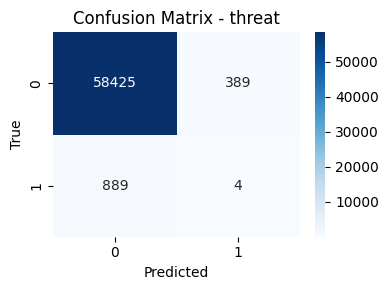


Confusion Matrix for 'insult':
[[27700 10593]
 [15564  5850]]


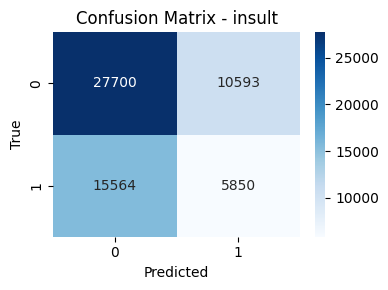


Confusion Matrix for 'identity_attack':
[[55853  1201]
 [ 2582    71]]


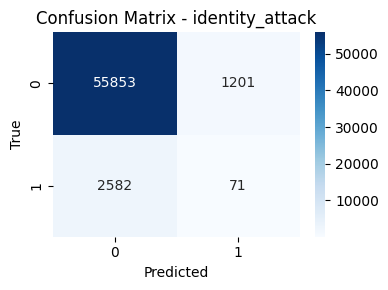


Confusion Matrix for 'sexual_explicit':
[[58259   529]
 [  910     9]]


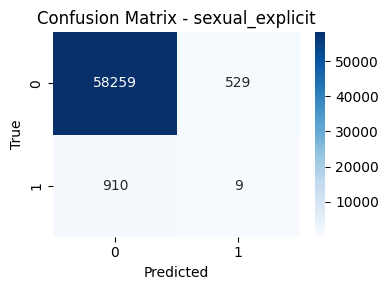


Classification Report:
                 precision    recall  f1-score   support

       toxicity       0.49      0.40      0.44     29111
severe_toxicity       0.00      0.00      0.00         2
        obscene       0.03      0.02      0.03      1965
         threat       0.01      0.00      0.01       893
         insult       0.36      0.27      0.31     21414
identity_attack       0.06      0.03      0.04      2653
sexual_explicit       0.02      0.01      0.01       919

      micro avg       0.40      0.31      0.35     56957
      macro avg       0.14      0.10      0.12     56957
   weighted avg       0.39      0.31      0.34     56957
    samples avg       0.16      0.16      0.15     56957



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Category names
label_names = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

# Dump val data
y_true = []
for batch in val:
    _, labels = batch
    y_true.append(labels)

y_true = np.concatenate([y.numpy() for y in y_true], axis=0)

#Convert y_true to binary data (0 or 1)
y_true_binary = (y_true >= 0.5).astype(int)

# Predictions
y_pred = model.predict(val)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Confusion matrices for each classification
for i, label in enumerate(label_names):
    print(f"\nConfusion Matrix for '{label}':")
    cm = confusion_matrix(y_true_binary[:, i], y_pred_binary[:, i])
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Full Performance Report
print("\nClassification Report:")
print(classification_report(
                            y_true_binary,
                            y_pred_binary,
                            target_names=label_names,
                            zero_division=0
                            ))


In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Performance measure for each classification
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in val:
    X_true, y_true = batch

    # Making predictions as tensors
    yhat = model(X_true, training=False)

    # Convert values ​​to binary
    y_true_binary = tf.cast(y_true >= 0.5, tf.float32)
    yhat_binary = tf.cast(yhat >= 0.5, tf.float32)

    # Update metrics
    pre.update_state(y_true_binary, yhat_binary)
    re.update_state(y_true_binary, yhat_binary)
    acc.update_state(y_true_binary, yhat_binary)


print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9176629781723022, Recall: 0.7034605145454407, Accuracy: 0.9509871006011963


In [ ]:
from google.colab import files


files.download('best_modelM40000output_sequence_length600.keras')
files.download('dataset_splits.npz')
files.download('best_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


label_names = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

for i, label in enumerate(label_names):
    y_true_col = y_true_binary[:, i]
    y_pred_col = y_pred[:, i]
    y_pred_binary_col = (y_pred_col >= 0.5).astype(int)

    precision = precision_score(y_true_col, y_pred_binary_col, zero_division=0)
    recall = recall_score(y_true_col, y_pred_binary_col, zero_division=0)
    f1 = f1_score(y_true_col, y_pred_binary_col, zero_division=0)

    # AUC only if there is diversity in values ​​(i.e. not all 0 or 1)
    try:
        auc = roc_auc_score(y_true_col, y_pred_col)
    except ValueError:
        auc = "Not calculable (only one label)"

    print(f"\nPerformance for category: {label}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc}")


ValueError: Found input variables with inconsistent numbers of samples: [59, 59707]

In [ ]:
import numpy as np
import tensorflow as tf

# Specify the number of rows in the train section where the value >= 0.5 for each class
def count_class_rows(dataset):
    class_counts = {label: 0 for label in range(len(label_names))}

    for batch in dataset:
        X, y_true = batch
        y_true_numpy = y_true.numpy()
        y_true_binary = (y_true_numpy >= 0.5).astype(int)

        # Count the number in each category
        for i in range(len(label_names)):
            class_counts[i] += np.sum(y_true_binary[:, i])

    return class_counts

# Calculate the distribution of classes in the train section
train_class_counts = count_class_rows(train)
print(f"Distribution of classes in the train dataset:")
for label, count in train_class_counts.items():
    print(f"{label_names[label]}: {count} samples")

# Calculate the distribution of classes in the val section
val_class_counts = count_class_rows(val)
print(f"\nDistribution of classes in the validation dataset:")
for label, count in val_class_counts.items():
    print(f"{label_names[label]}: {count} samples")


In [ ]:
y_train_binary

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


class_weights = []
for i in range(y_train_binary.shape[1]):
    class_weights.append(compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train_binary[:, i]
    )[1])

# Convert weights to dictionary
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"Calculated Class Weights: {class_weights_dict}")


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, GlobalAveragePooling1D, GlobalMaxPooling1D


inputs = Input(shape=(600,))

embedding_layer = Embedding(MAX_WORDS+1, 32)(inputs)


bi_lstm = Bidirectional(LSTM(32, activation='tanh', return_sequences=True))(embedding_layer)

dropout = Dropout(0.3)(bi_lstm)

# Attention
attention = Attention()([bi_lstm, bi_lstm])

# Merge outputs using GlobalAveragePooling1D
attention = GlobalMaxPooling1D()(attention)

dense1 = Dense(128, activation='relu')(attention)
dense2 = Dense(256, activation='relu')(dense1)
dense3 = Dense(128, activation='relu')(dense2)
dense4 = Dense(256, activation='relu')(dense3)

output = Dense(7, activation='sigmoid')(dense4)

model = Model(inputs=inputs, outputs=output)

model.summary()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC
import tensorflow as tf

# Compile with metrics appropriate to the task.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

In [ ]:
history = model.fit(train,
                    epochs=13,
                    validation_data=val,
                    batch_size=32,
                    class_weight=class_weights_dict,
                    callbacks=[early_stop, checkpoint]
                   )

In [ ]:
model.save('best_modelM40000output_sequence_length600_Attention_ClassWeights.keras')
print("model saved successfully!")

In [ ]:
from google.colab import files

files.download('best_modelM40000output_sequence_length600_Attention_ClassWeights.keras')


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Category names
label_names = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

# Dump val data
y_true = []
for batch in val:
    _, labels = batch
    y_true.append(labels)

y_true = np.concatenate([y.numpy() for y in y_true], axis=0)

#Convert y_true to binary data (0 or 1)
y_true_binary = (y_true >= 0.5).astype(int)

# Predictions
y_pred = model.predict(val)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Confusion matrices for each classification
for i, label in enumerate(label_names):
    print(f"\nConfusion Matrix for '{label}':")
    cm = confusion_matrix(y_true_binary[:, i], y_pred_binary[:, i])
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Full Performance Report
print("\nClassification Report:")
print(classification_report(
                            y_true_binary,
                            y_pred_binary,
                            target_names=label_names,
                            zero_division=0
                            ))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


label_names = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

for i, label in enumerate(label_names):
    y_true_col = y_true_binary[:, i]
    y_pred_col = y_pred[:, i]
    y_pred_binary_col = (y_pred_col >= 0.5).astype(int)

    precision = precision_score(y_true_col, y_pred_binary_col, zero_division=0)
    recall = recall_score(y_true_col, y_pred_binary_col, zero_division=0)
    f1 = f1_score(y_true_col, y_pred_binary_col, zero_division=0)

    # AUC only if there is diversity in values ​​(i.e. not all 0 or 1)
    try:
        auc = roc_auc_score(y_true_col, y_pred_col)
    except ValueError:
        auc = "Not calculable (only one label)"

    print(f"\nPerformance for category: {label}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc}")


In [ ]:
input_text = tf.constant("Fuck you son of the pitch!")

# Convert text to a digital representation in the same format as the training data.
vectorized_input = vectorizer(input_text)

res = model.predict(vectorized_input)

binary = (res >= 0.5).astype(int)

print(binary)
